<a href="https://colab.research.google.com/github/IlyaKo4atkov/OpenCV/blob/main/_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. ВВОДНАЯ ЧАСТЬ


*   ТЕМА: Применение YOLO для детекции объектов в условиях сложной освещенности.
*   АВТОР: Кочатков И.А.
*   НАПРАВЛЕНИЕ: Исследование методов улучшения YOLO для детекции объектов в условиях сложной освещенности.



# 2. Теоретическая часть

# Применение YOLO для детекции объектов в условиях сложной освещенности.

*   В качестве обнаружения объектов выступает архитектура YOLO v3
*   Основными методами улучшения YOLO для детекции объектов в условиях сложной освещенности являются: предобработка данных, модификация архитектуры модели и обучение с учетом условий освещенности

`YOLO v3` (You Only Look Once, версия 3) — это алгоритм обнаружения объектов в реальном времени.

`Основная цель алгоритма` — высокоточное распознавание объектов, что делает его подходящим для приложений, требующих быстрой реакции, таких как автономные автомобили, видеонаблюдение и дополненная реальность.


# 3. УСТАНОВКА И ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК

In [ ]:
# Обработка изображений
import cv2
from PIL import Image

# Линейная алгебра
import numpy as np

# Графики
from matplotlib import pyplot as plt


# Фреймворки Keras и Tensorflow
import tensorflow as tf
from tensorflow.keras import Model                                                              # создание модели
from tensorflow.keras.layers import Add, Concatenate, Lambda                                    # методы сложения, объединения и обертывания слоев
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU                                    # импорт сверточных нейронных сетей
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D, BatchNormalization  # Импортирует слои для обработки и улучшения изображений
                                                                                                 '''MaxPool2D: Слой максимальной подвыборки, уменьшает размерность признаков и увеличивает поле восприятия
                                                                                                 UpSampling2D: Слой повышения дискретизации, увеличивает размерность признаков.
                                                                                                 ZeroPadding2D: Слой добавления нулевой границы, добавляет нули вокруг изображения или признаковой карты.
                                                                                                 BatchNormalization: Слой нормализации пакета, нормализует выходные данные предыдущего слоя для ускорения обучения и улучшения стабильности.'''
from tensorflow.keras.regularizers import l2                                                    # Импортирует регуляризатор L2, используемый для предотвращения переобучения путем добавления штрафа к большим весам.
from tensorflow.keras.losses import binary_crossentropy                                         # Импортирует функцию потерь binary_crossentropy, используемую для задач бинарной классификации.
from tensorflow.keras.losses import sparse_categorical_crossentropy                             # Импортирует функцию потерь sparse_categorical_crossentropy, используемую для задач многоклассовой классификации, где метки представлены целыми числами.

from itertools import repeat

### Вспомагательные блоки

#### DarkNet Block Layer (DBL)

Блок DBL, который представляет собой каскад сверточных слоев. Функция  DBL на вход принимает следующие аргументы:
* x - тензор входных данных
* filter - количество фильтров на слой, целое число
* kernel - размер ядра свертки, целое число
* stride - шаг свертки, целое число
* batch_norm - включать ли ветку со слоем BatchNormalization и функцией активации LeakyReLu.


In [ ]:
def DBL(x, filters, kernel, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        # Делается oтступ в виде нулей по контуру изображения, что бы был захвачен левый верхний угол
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm,  # использлвание смещения, если отсутствует нормализация
              kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001)(x)
        x = LeakyReLU(negative_slope=0.1)(x)
    return x



#### Блок **ResUnit**

Функция ResUnit реализует ячейку Residual блока (блок с остаточными связями). Остаточные связи позволяют сохранить извлеченные из изображения карты признаки и передать их на более глубокие слои. Что позволяет сохранить звлеченную информацию в очень глубоких сетях.

Функция Res_unit использует функцию DBL с разными настройками количества фильтров и ядра свертки. Параметры ядра свертки kernel задаются жестко внутри функции.  Для первой `DBL` размер ядра 1, для второй - 3.

Шаг свертки `stride = 1`, установлен по умолчанию в функции DBL и не изменяется.

На входе функции создается прямое соединение `skip_connection` с выходом.

In [ ]:
def ResUnit(x, filters):
    skip_connection  = x
    x = DBL(x, filters // 2, 1)
    x = DBL(x, filters, 3)
    x = Add()([skip_connection , x])
    return x

#### Блок **ResN**

Функция `ResN` реализует `Residual` блок заданных размеров. Сеть Darknet-53 использует Residual блоки кратностью  $×1,×2,×4,×8$ .


Функция получает на вход тензор $x$, который проходит через слой Conv2D с ядром свертки 3х3 и шагом свертки 2 (внутри блока DBL), и его размерность уменьшается в два раза, а затем он проходит через `n` `ResUnit` блоков.

In [ ]:
def ResN(x, filters, blocks):
    x = DBL(x, filters, kernel=3, strides=2) # ядро и шаги
    for _ in repeat(None, blocks): # цикл по n-блокам (подход с repeat позволяет экономить память)
        x = ResUnit(x, filters)
    return x

### Сеть Darknet (BackBone)

Каскад сверточных слоев (DBL) и остаточных блоков (ResN) позволяют максимально извлекать визуальную информацию из изображения (форма объектов, цвет, яркость, и т.д.). YOLOv3 использует 3 выхода из сети Darknet-53 для извлечения признаков в трех масштабах Route 1, Route 2 и Route 3.


In [ ]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DBL(x, 32, 3)
    x = ResN(x, 64, 1)
    x = ResN(x, 128, 2)
    x = Route_1 = ResN(x, 256, 8)
    x = Route_2 = ResN(x, 512, 8)
    Route_3 = ResN(x, 1024, 4)
    return tf.keras.Model(inputs, (Route_1, Route_2, Route_3), name=name)

## Использование аугментации данных для синтетического увеличения объема данных.

### Это один из возможных методов исследования для улучшения детекции объектов в том числе и с плохой освещённостью.

In [ ]:
import imgaug.augmenters as iaa
import imageio

# Определение последовательности аугментации
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # горизонтальное отражение с вероятностью 50%
    iaa.Affine(rotate=(-20, 20)),  # случайный поворот от -20 до 20 градусов
    iaa.Multiply((0.8, 1.2)),  # случайное изменение яркости
    iaa.GaussianBlur(sigma=(0, 3.0))  # случайное размытие
])

# Применение аугментации к каждому изображению
augmented_images = seq(images=[image] * 5)

# Проведение нормализации изображений в датасете

Процесс изменения диапазона значений пикселей изображения, называемый нормализацией, полезен в первую очередь для улучшения качества для подготовки данных машинного обучения.То есть это линейная нормализация, которая изменяет значение пикселей так, что бы они находились в заданном диапазоне.

In [ ]:
import cv2

# Загрузка изображения
image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

# Преобразование изображения в тип float32 для нормализации
image_float = image.astype(np.float32)

# Нормализация изображения в диапазон [0, 1]
normalized_image = cv2.normalize(image_float, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Отображение оригинального и нормализованного изображений
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Исходное изображение')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Изображени после нормализации')
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.show()


### Головы YOLOv3

### Класс YoloHead создает необходимое количество голов, где каждая голова отвечает за предсказание объектов на разных масштабах. Это позволяет модели лучше справляться с объектами разного размера.

In [ ]:
def YoloHead(filters, name=None):
    def layer(x_in):
        if isinstance(x_in, tuple): #
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DBL(x, filters, 1)
            x = UpSampling2D(2)(x)            # увеличивает размер изображения
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return layer

def YoloHeadOutput(filters, anchors, classes, name=None):
    def layer(x_in):

        x = inputs = Input(x_in.shape[1:])
        x = DBL(x, filters * 2, 3)
        x = DBL(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return layer

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

### Функция преобразования предсказаных значений в рамки (yolo_boxes)

Сетка разделяет входное изображение на ячейки, каждая из которых отвечает за обнаружение объектов, центры которых попадают в эту ячейку.

Якорные рамки - это набор предварительно определенных рамок разных размеров и соотношений сторон, которые используются для облегчения обучения модели предсказанию ограничивающих рамок объектов. Они помогают сети лучше справляться с обнаружением объектов разных форм и размеров.

Каждая ячейка сетки напрямую предсказывает координаты, ширину и высоту ограничивающей рамки относительно самой ячейки. Это работало, но было сложно для сети научиться предсказывать рамки, сильно отличающиеся по форме и размеру.

In [ ]:
def yolo_boxes(pred, anchors, classes):
    # На входе pred размера (S, S, 3, (1+4+80))

    grid_size = tf.shape(pred)[1] # S ячеек в сетке

    # В box_xy и box_wh помещаеется сразу в 2 переменные (tx, ty) и (tw, th)
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1) # раскладывание предсказанной карты по переменным

    # применение сигмоидных функций
    box_xy = tf.sigmoid(box_xy)                     # sigmoid - нелинейная функция активации, от 0 до 1
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)


    # Построение сетки S x S
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    # Привязка box_xy к ячейкам сетки, с учетом смещения (нормализация к диапазону 0, 1)
    # Фактически идет вычисление центрального положения рамки относительно размеров сетки (якорного поля)
    b_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32) # вычисление b_xy: (bx, by)

    b_wh = tf.exp(box_wh) * anchors # вычисление b_wh: (bw, bh), ширина и высота рамки bbox

    box_x1y1 = b_xy - b_wh / 2
    box_x2y2 = b_xy + b_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) # задание рамки bbox, как 2 координаты углов


    return bbox, score, class_probs, pred_box

### Подавление не максимумов NMS

Модель YOLOv3 рассчитывает вероятности для 10 647 базовых якорных рамок. После вычисления параметра **score** (confidence), все якорные рамки не содержащие объекты удаляются. Остаются только те, у которых вероятность содержания в них объекта выше заданного порога.

К оставшимся рамкам применяют алгоритм `NMS`. Алгоритм `NMS` берет две рамки (bounding boх) с наибольшими вероятностями, например 0.98 и 0.99, и вычисляет между ними `IoU` и если значение превышает заданный порог `YOLO_IOU_THRESHOLD`, то данная рамка ограничивает один и тот же объект, соответственно рамку (bboх) с меньшей вероятностью можно удалить.

Затем берется следующая по вероятности рамка и т.д. до тех пор пока не останется только одна.

Если же `IoU` ниже заданного порога, то скорее всего рамки описывают два разных объекта, в этом случае обе рамки остаются.

Для решения заданной задачи используется готовый алгоритм `tf.image.combined_non_max_suppression`.

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    # Блок преобразования трех выходов разных масштабов
    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    # Конкатенация трех масштабов в один
    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs # Оценки считаются как произведение оценок объектности на вероятности классов

    # Применение NMS из пакета tensorflow
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=YOLO_IOU_THRESHOLD,
        score_threshold=YOLO_SCORE_THRESHOLD)

    return boxes, scores, classes, valid_detections

# 4.ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ YOLO v3

Определение констант для модели:

In [ ]:
YOLO_IOU_THRESHOLD = 0.6 # порог для оценок перекрытия IOU в NMS (параметр iou_threshold в tf.image.combined_non_max_suppression)
YOLO_SCORE_THRESHOLD = 0.6 # порог для оценок scores применяется в NMS (параметр score_threshold в tf.image.combined_non_max_suppression)

WEIGHT_YOLO_V3 = 'yolov3.weights' # путь к файлу с предобученными весами
SIZE = 416 # изменение изображения до соответствующих размеров
CHECKPOINTS = 'yolov3.weights.h5' # путь сохранения весов модели
NUM_CLASSES = 80 # число классов, на которых обучена модель

Загрузка предобученных весов.

Файл yolov3.weights содержит предварительно обученные веса (параметры) нейронной сети YOLOv3. Эти веса были получены в результате обучения модели на большом наборе данных изображений, таком как COCO (Common Objects in Context), с целью научить ее обнаруживать различные объекты.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/CV/yolov3.weights

--2025-04-23 17:34:51--  https://storage.yandexcloud.net/academy.ai/CV/yolov3.weights
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/x-www-form-urlencoded]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  31.4MB/s    in 9.3s    

2025-04-23 17:35:01 (25.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
YOLO_V3_LAYERS = [
    'yolo_darknet',
    'yolo_head_1',
    'yolo_output_1',
    'yolo_head_2',
    'yolo_output_2',
    'yolo_head_3',
    'yolo_output_3'
]

Окончательная сборка модели

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=80, training=False):
    # Вход
    x = inputs = Input([size, size, channels])

    # Модель Darknet с тремя выходами
    Route_1, Route_2, Route_3 = Darknet(name='yolo_darknet')(x)

    # Определение 3-х голов с разным числом фильтров
    x = YoloHead(512, name='yolo_head_1')(Route_3)
    output_0 = YoloHeadOutput(512, len(masks[0]), classes, name='yolo_output_1')(x)

    x = YoloHead(256, name='yolo_head_2')((x, Route_2))
    output_1 = YoloHeadOutput(256, len(masks[1]), classes, name='yolo_output_2')(x)

    x = YoloHead(128, name='yolo_head_3')((x, Route_1))
    output_2 = YoloHeadOutput(128, len(masks[2]), classes, name='yolo_output_3')(x)

    if training: # определение модели для обучения
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # Перегон предсказанных якорных рамок в boundary box для трех выходов
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    # Отсечение всего лишнего алгоритмом NMS
    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3') # возвращение модели для инференса

Определение функции загрузки весов:

In [ ]:

def load_darknet_weights(model, weights_file):

    wf = open(weights_file, 'rb') # загрузка файла с весами

    # Чтение из файла по элементам (первые 5, версия файла)
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLO_V3_LAYERS # слои для загрузки

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)      # извлечение блоков слоев из модели по имени
        for i, layer in enumerate(sub_model.layers): # прохождение по отдельным слоям блоков
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                sub_model.layers[i + 1].name.startswith('batch_norm'):
                    batch_norm = sub_model.layers[i + 1]  # фиксация если за слоем будет батч-нормализация



            filters = layer.filters                   # фильтров в слое
            size = layer.kernel_size[0]               # размер ядра в слое
            #in_dim = layer.input_shape[-1]           # input_shape в слоях Conv2d больше не поддерживается
            in_dim = layer.get_weights()[0].shape[2]  # входная размерность слоя

            # если отсутствует нормализация, то добавляется смещение
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters) # считывание весов для смещения
            else:
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4*filters) # считывание весов для нормализации
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]     # изменение формы

            conv_shape = (filters, in_dim, size, size)    # размерность сверточного слоя
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.prod(conv_shape))  # считывание веса для сверточного слоя
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0]) # изменение формы данных весов

            # Если нет нормализации, то добавляются веса + смещение
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                # Если есть нормализации, то добавляются веса в сверточный слой и в следующий за ним слой нормализации
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read weights'   # генерируется исключение, если файл не читается
    wf.close()

### Вспомагательные функции

#### Функция вычисления IoU

IoU (Intersection over Union) выражает отношение площади пересечения рамок к площади их объединения. Метрика необходима для определения степени перекрытия двух ограничивающих рамок (bounding box) и используется для фильтрации дублирующих обнаружений с помощью заданного порогового значения.

Функция interval_overlap вычисляет длину пересечения двух отрезков на одной оси (X или Y).

In [ ]:
def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1 # координаты начала и конца первого отрезка
    x3, x4 = interval_2 # координаты начала и конца второго отрезка
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2,x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2,x4) - x3)

Параметры функции:
- interval_1: список/кортеж из двух значений $[x1, x2]$, где:
  - $x1$: координата начала первого отрезка
  - $x2$: координата конца первого отрезка
- interval_2: список/кортеж из двух значений $[x3, x4]$, где:
  - $x3$: координата начала второго отрезка
  - $x4$: координата конца второго отрезка


Имея вспомагательную функцию, можно легко выразить IoU по формулам

In [ ]:

def intersectionOverUnion(box1, box2): # box1, box2 - координаты рамки
    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    return float(intersect_area) / union_area # возвращает значение IoU

#### Функция потерь

Далее необходимо определить пользовательскую функцию потерь или функцию ошибки YOLOv3. Вычисление потерь включает алгоритмы для исключения ложных срабатываний на основе порогов IoU и учитывает размер ячеек. Функция оценивает расхождения между прогнозируемыми и истинными значениями в ограничивающих рамках, оценках объектности и вероятностях классов, фиксируя тонкости идентификации объектов в стиле YOLO и помогая повысить точность модели во время обучения.

Функция ошибки состоит из четырех частей:
* `xy_loss` - ошибка положения (xy)
* `wh_loss` - ошибка ширины и высоты(wh)
* `obj_loss` - ошибка объектности (наличие объекта в ячейке)
* `class_loss` - ошибка классификации

Или все вместе: `loss = xy_loss + wh_loss + obj_loss + class_loss`



In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):

        # 1. Преобразование всех предсказанных выходов
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. Преобразование всех реальных значений
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # Чем меньше рамка, тем больше ошибка
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. Инвертирование  уравнений красного прямоугольника inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        # 4. Вычисление ignore_mask
        obj_mask = tf.squeeze(true_obj, -1)
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(intersectionOverUnion(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. Вычисление всех функций ошибок
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)

        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        # binary_crossentropy или sparse_categorical_crossentropy
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. Все функции ошибок суммируются по осям для каждого пакета (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        # Общая суммарная ошибка
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

Функция `transform_targets_for_output` преобразует ограничивающие рамки в целевой тензор, адаптированный для конкретной выходной сетки в модели обнаружения объектов, с учетом информации о блоках привязки, положениях сетки и достоверности определения объекта, что облегчает обучение архитектурам, подобным YOLO.

Функция `transform_targets` подготавливает целевые тензоры для моделей обнаружения объектов, подобных `YOLO`, путем включения меток определения истинности, блоков привязок и информации о классе. Он вычисляет индексы привязки на основе пересечений при объединении, добавляет их к меткам и генерирует целевые тензоры для нескольких выходных сеток с различными масштабами, что важно для эффективного обучения модели.

Эти функции работают вместе, чтобы подготовить метки истинности для обучения `модели YOLO` с несколькими выходными масштабами и конфигурациями привязок.

#### Преобразование ограничивающих рамок

Функция `transform_targets_for_output` преобразует ограничивающие рамки в целевой тензор, адаптированный для конкретной выходной сетки в модели обнаружения объектов, с учетом информации о блоках привязки, положениях сетки и достоверности определения объекта, что облегчает обучение архитектурам, подобным YOLO.

Функция `transform_targets` подготавливает целевые тензоры для моделей обнаружения объектов, подобных YOLO, путем включения меток определения истинности, блоков привязок и информации о классе. Он вычисляет индексы привязки на основе пересечений при объединении, добавляет их к меткам и генерирует целевые тензоры для нескольких выходных сеток с различными масштабами, что важно для эффективного обучения модели.

Эти функции работают вместе, чтобы подготовить метки истинности для обучения модели YOLO с несколькими выходными масштабами и конфигурациями привязок.

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

#### Функции детекции объектов и отображения предсказанной рамки

Функция `draw_outputs` отображает на изображении `img` ограничивающие рамки , имена классов, вероятности объектов, которые сетка нам предсказала.

Предсказанные данные для отображения вычисляются в функции `detect_objects`, которой на вход подается путь до изображения и `white_list` (используется для ограничения классов, по которым проводить детекцию).

# 5.ОЦЕНКА РЕЗУЛЬТАТОВ

In [ ]:
yolo = YoloV3(classes=NUM_CLASSES)

load_darknet_weights(yolo, WEIGHT_YOLO_V3)

yolo.save_weights(CHECKPOINTS)

class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
                "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


In [ ]:
def draw_outputs(img, outputs, class_names, white_list=None, thickness=2):
    boxes, scores, classes, nums = outputs # координаты прямоугольника, оценка уверенности, индекс классов, кол-во объектов
    for i in range(nums[0]): # цикл по обнаруженным объектам
        if white_list is None or class_names[int(classes[0][i])] in white_list:
            x1y1 = tuple((boxes[0][i][0:2] * [img.shape[1], img.shape[0]]).astype(int)) # вычисление координат прямоугольника у обнаруженного объекта
            x2y2 = tuple((boxes[0][i][2:4] * [img.shape[1], img.shape[0]]).astype(int))
            img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), thickness) # рисование прямоугольника с заданым цветом и толщиной
            img = cv2.putText(img, '{} {:.4f}'.format(class_names[int(classes[0][i])], scores[0][i]),
                              x1y1, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness) # добавление текста на рамку
    return img


In [ ]:
def detect_objects(img_path, white_list=None, thickness=2):
    image = img_path  # путь к файлу
    img = tf.image.decode_image(open(image, 'rb').read(), channels=3)  # загрузка изображения как тензор

    img = tf.expand_dims(img, 0)  # добавление размерности
    img = preprocess_image(img, SIZE)  # ресайз изображения
    boxes, scores, classes, nums = yolo.predict(img)  #  предсказание

    img = cv2.imread(image)  # считывание изображения как картинку, чтобы на нем в дальнейшем рисовать
    # Отрисовка на картинке предсказанных объектов
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names, white_list, thickness)

    # Сохранение изображения с предсказанными объектами
    cv2.imwrite('detected_{:}'.format(img_path), img)

    # Открытие сохраненных изображений и вывод на экран
    detected = Image.open('detected_{:}'.format(img_path))
    detected.show()
    plt.imshow(detected)


### Изображение 1
Освещенность на хорошем уровне

In [ ]:
import gdown

# URL файла на Google Drive
url = 'https://drive.google.com/uc?id=1pEK2KMgjS1O1eopSDI0yrIYJinUkZUb3'

# Имя файла, под которым он будет сохранен
output = 'banana.jpg'

# Загрузка файла
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1pEK2KMgjS1O1eopSDI0yrIYJinUkZUb3
To: /content/banana.jpg
100%|██████████| 3.26M/3.26M [00:00<00:00, 192MB/s]


'banana.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


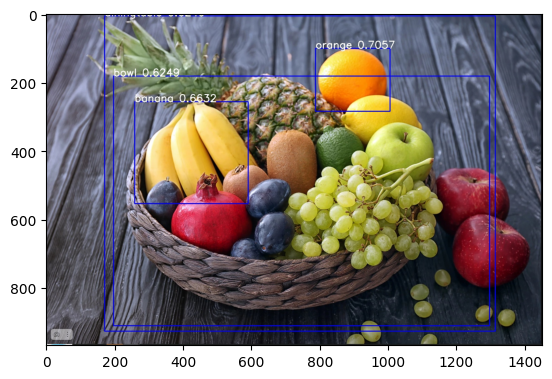

In [ ]:
# Задаем в white_list список искомых объектов

detect_objects("banana.jpg", class_names)

### Определение объектов на изображении со сложной освещенностью

In [ ]:
import gdown

# URL файла на Google Drive
url = 'https://drive.google.com/uc?id=1E9VkuKE2XzlnCDfEEsxRDcyhciFO1SWl'

# Имя файла, под которым он будет сохранен
output = 'fruct.jpg'

# Загрузка файла
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1E9VkuKE2XzlnCDfEEsxRDcyhciFO1SWl
To: /content/fruct.jpg
100%|██████████| 104k/104k [00:00<00:00, 40.0MB/s]


'fruct.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


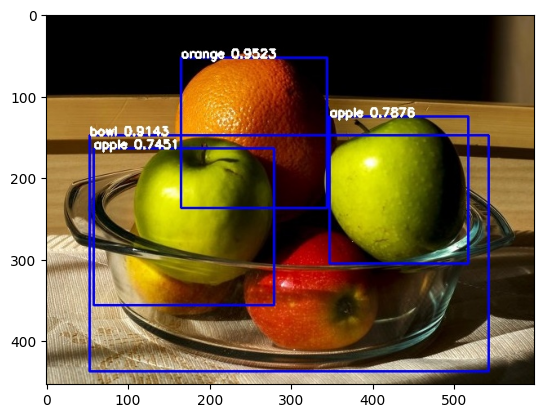

In [ ]:
# Задаем в white_list список искомых объектов

detect_objects('fruct.jpg', class_names)

In [ ]:

# URL файла на Google Drive
url = 'https://drive.google.com/uc?id=1raKCZVOHCGqye0T6UUdyUUvhL71WVI66'

# Имя файла, под которым он будет сохранен
output = 'fruct1.jpg'

# Загрузка файла
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1raKCZVOHCGqye0T6UUdyUUvhL71WVI66
To: /content/fruct1.jpg
100%|██████████| 134k/134k [00:00<00:00, 60.5MB/s]


'fruct1.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


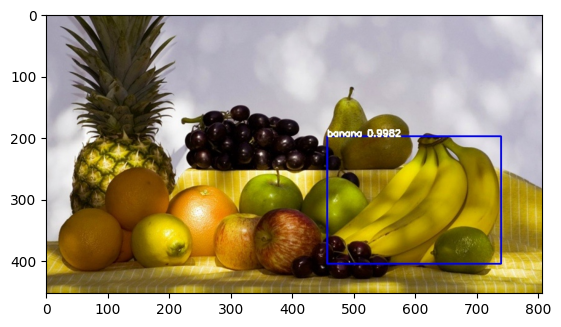

In [ ]:
# Задаем в white_list список искомых объектов

detect_objects('fruct1.jpg', ['banana', 'orange'])

In [ ]:

# URL файла на Google Drive
url = 'https://drive.google.com/uc?id=1evyRREvG8ZvnHtqeTVe1ueljBO8CfTh3'

# Имя файла, под которым он будет сохранен
output = 'fruct3.jpg'

# Загрузка файла
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1evyRREvG8ZvnHtqeTVe1ueljBO8CfTh3
To: /content/fruct3.jpg
100%|██████████| 145k/145k [00:00<00:00, 74.3MB/s]


'fruct3.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


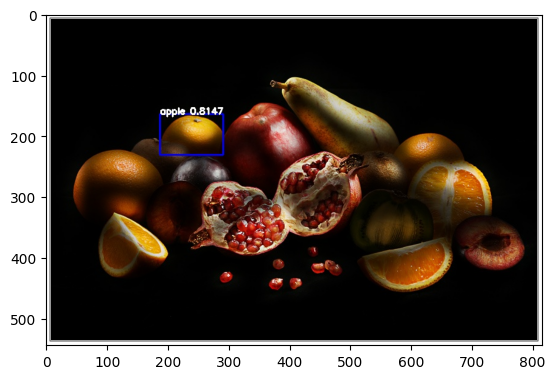

In [ ]:
# Задаем в white_list список искомых объектов

detect_objects('fruct3.jpg', class_names)

# 6.ВЫВОДЫ

Результат исследования работы модели YOLO v3 показал следующие результаты:
*   С увеличением затемненности изображения, распознавание объектов уменьшается.

*   Но даже с такой яркостью результат стал неплохим, так как я использовал базовые методы улучшения распознавания объектов, такие как аугментация данных, модификация архитектуры модели и обучение с учетом условий освещенности.

Так же в качестве исследовательских методов приведу примеры методов, которые были бы полезны для детекции объектов, в практической работе они были не рассмотрены подробно, так как  для всех методов не хватило бы мощности среды разработки.
Для улучшения алгоритма `YOLO (You Only Look Once)` в условиях сложной освещенности можно рассмотреть несколько методов и подходов. Вот некоторые из них:



1.   Предобработка данных

*   Аугментация данных - использование техник аугментации, таких как изменение яркости, контраста, добавление шума, чтобы сделать модель более устойчивой к изменениям освещенности. Данный метод я использовал в разработке архитектуры модели YOLO.

*   Нормализация изображений - применение методов нормализации для выравнивания освещенности на изображениях. Данный метод я так же использовал, что очень сказалось на итоговом определении объектов на изображении.


2.   Модификация архитектуры модели:


*   Использование улучшенных слоев - внедрение более сложных слоев, таких как SE-блоки которые могут помочь модели лучше фокусироваться на важных частях изображения.

*   Адаптивные методы - внедрение механизмов внимания (attention mechanisms), которые могут помочь модели выделять важные области изображения, несмотря на плохую освещенность.


3.   Обучение с использованием дополнительных данных:


*   Синтетические данные - создание синтетических данных с различными условиями освещенности для обучения модели.

*   Использование предобученных моделей - начало обучения с моделей, предобученных на больших наборах данных, которые включают разнообразные условия освещенности.


2.   Постобработка результатов:


*   Фильтрация и улучшение изображения - применение фильтров для улучшения качества изображений перед подачей их в модель.

*   Улучшение детекции - использование методов постобработки, таких как не максимальное подавление, для улучшения точности детекции.



5.   Обучение с учетом условий освещенности:


*   Многоуровневое обучение - обучение модели на различных уровнях освещенности, чтобы она могла адаптироваться к различным условиям.

*   Обучение с использованием меток освещенности - включении информации об освещенности в процессе обучения, чтобы модель могда учитывать это при детекции.



2.   Использование дополнительных сенсоров:


*   Инфракрасные камеры - использование инфракрасных изображений в дополнение к обычным, что бы улучшить детекцию в условиях низкой освещенности.

*   Лидары и другие сенсоры - интеграция дынных с другими сенсорами для улучшения общей точности детекции.

Как видно все эти методы могут быть использованы и протестированы для улучшения производительности `YOLO v3` в `условиях сложной освещенности`. Выбор подхода зависит от конкретных требований и ограничений виртуальной среды разработки Google Colab.















